In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
#create the initial dataframe using CSV file

df = pd.read_csv("Vendors-full.csv", delimiter=',')
df['State Code'] = df['City/State'].str[-2:]
shuffled = df.sample(frac=1)
shuffled.head()

,Vendor Number,Vendor Name,Street Address,City/State,Zip Code,Country,Phone Number,Fax Number,E-mail Address,Status,User Name,Payment Terms Code,Payment Terms,Secondary Buyer,State Code
1422,201424,"Measurlogic, Inc.","7334 S. Alton Way, Suite 14M","Centennial, CO",80112,United States,303-805-5252,425-799-4780,NaN,Active,CFancy,7,"1% 10 Days, Net 30 Days",Sherdell.Hord,CO
2013,202016,GBS (Singapore) Pte Ltd,"2 Serangoon North Ave 5, #04-02, S 554911",NaN,554911,Singapore,67592237,67595266,derek_ng@gbs.com.sg,Active,lpulfer,6,Net 30 Days,DWasp,NaN
2438,202441,Teknipure LLC,2150 W Broadway Rd Ste 104,"Mesa, AZ",85202,United States,480-821-3182,480-452-1263,cust-serv@teknipure.com,Active,camilleg,43,Net 120 Days,camilleg,AZ
184,200176,Setra Systems,159 Swanson Road,"Boxboro, MA",1719,United States,800-257-3872,NaN,NaN,Active,CFancy,6,Net 30 Days,AMetz,MA
2270,202273,Amphenol Cables on Demand,20 Valley St,"Endicott, NY",13760,United States,866-223-2860,607-321-2186,customerservice@cablesondemand.com,Active,CFancy,24,Credit Card,DWasp,NY


In [4]:
#create a dataframe only contains key attributes

data1 = df.groupby('State Code').count()[['Vendor Name']]
data1.reset_index(inplace=True)
data1.rename(columns = { 'State Code' : 'STATE', 'Vendor Name' : 'Vendor Count'}, inplace=True)
data1

,STATE,Vendor Count
0,2,2
1,7,1
2,*,2
3,",",1
4,.C,1
...,...,...
243,xx,2
244,"y,",1
245,ya,3
246,yo,12


In [5]:
#create a geodataframe using shape file

shp_gdf = gpd.read_file('s_22mr22.shp')
shp_gdf.head()

,STATE,NAME,FIPS,LON,LAT,geometry
0,AK,Alaska,02,-152.24098,64.24019,"MULTIPOLYGON (((-179.10754 51.30120, -179.1054..."
1,AL,Alabama,01,-86.82676,32.79354,"MULTIPOLYGON (((-88.11011 30.25891, -88.10638 ..."
2,AR,Arkansas,05,-92.43920,34.89977,"POLYGON ((-91.62986 36.49921, -91.62849 36.499..."
3,AS,American Samoa,60,-170.37215,-14.26486,"MULTIPOLYGON (((-170.77310 -14.36245, -170.773..."
4,AZ,Arizona,04,-111.66457,34.29323,"POLYGON ((-110.49090 37.00361, -110.48750 37.0..."


In [6]:
#merge two dataframes, this is the geodataframe that's ready to use

mergeo = shp_gdf.merge(data1, on='STATE', how='left')
mergeo.dropna(inplace=True)
mergeo.head()

,STATE,NAME,FIPS,LON,LAT,geometry,Vendor Count
1,AL,Alabama,01,-86.82676,32.79354,"MULTIPOLYGON (((-88.11011 30.25891, -88.10638 ...",1.0
2,AR,Arkansas,05,-92.43920,34.89977,"POLYGON ((-91.62986 36.49921, -91.62849 36.499...",3.0
3,AS,American Samoa,60,-170.37215,-14.26486,"MULTIPOLYGON (((-170.77310 -14.36245, -170.773...",1.0
4,AZ,Arizona,04,-111.66457,34.29323,"POLYGON ((-110.49090 37.00361, -110.48750 37.0...",340.0
5,CA,California,06,-119.60818,37.24537,"MULTIPOLYGON (((-118.42620 32.79973, -118.4263...",640.0


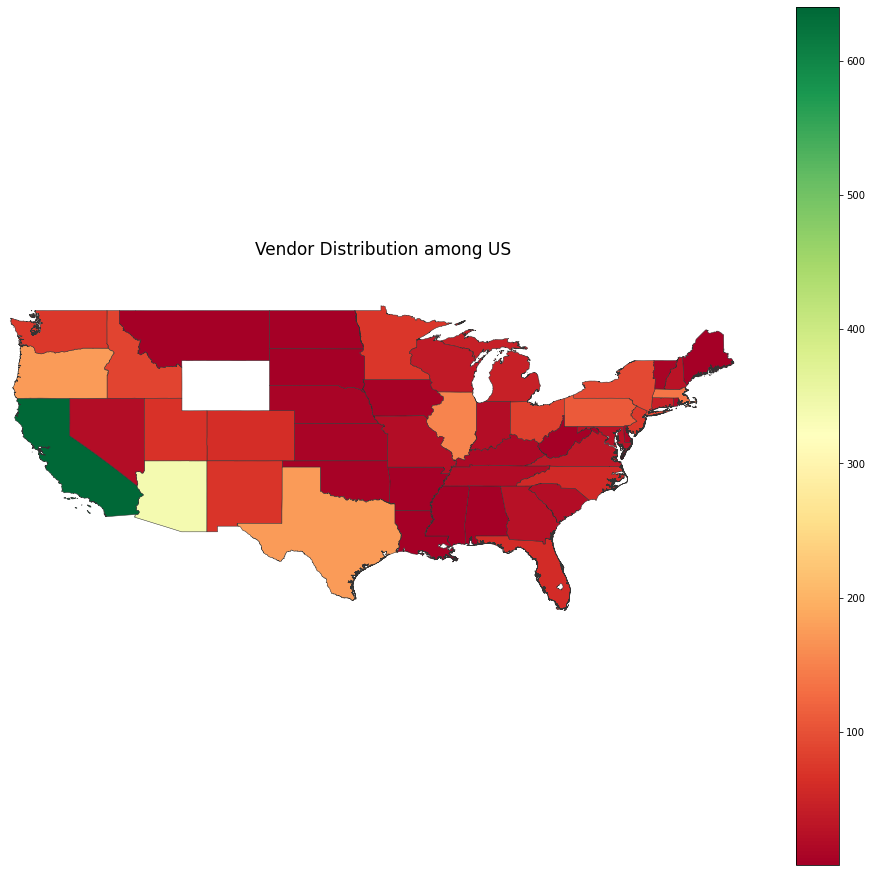

In [7]:
#plot vendor distribution in the U.S.

xlim = (-125, -65)
ylim = (25, 53)

fig, ax = plt.subplots(figsize=(12, 12), constrained_layout=True)
ax.axis('off')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title('Vendor Distribution among US',
             fontdict={'fontsize': '17', 'fontweight' : '3'})
fig = mergeo.plot(column='Vendor Count', cmap='RdYlGn', linewidth=0.5, ax=ax, edgecolor='0.2',legend=True)

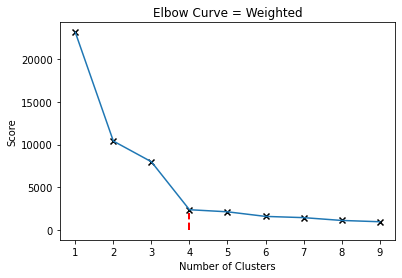

In [18]:
#decide the optimal qty of warehouse locations based on curreent vendor distribution, Elbow method 

K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]

lon_lat = mergeo[mergeo.columns[3:5]]
vendor_count = mergeo[mergeo.columns[6]]
sample_weight = lot_size
ori_score = [kmeans[i].fit(lon_lat, sample_weight = vendor_count).score(lon_lat) for i in range(len(kmeans))]
score = [abs(i) for i in ori_score]

plt.plot(K_clusters, score)
plt.scatter(K_clusters, score,marker='x', color='black')
plt.plot([4, 4], [0, 2000],color='red', linestyle='dashed',linewidth=2)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve = Weighted')
plt.show()

In [19]:
#calculate the optimal coordiantes for new warehouses

kmeans = KMeans(n_clusters = 4, max_iter=300, init ='k-means++')

lon_lat = mergeo[mergeo.columns[3:5]]
lot_size = mergeo[mergeo.columns[6]]
weighted_kmeans_clusters = kmeans.fit(lon_lat, sample_weight = lot_size) # Compute k-means clustering

mergeo['cluster_label'] = kmeans.predict(lon_lat, sample_weight = lot_size)

centers = kmeans.cluster_centers_   # Coordinates of cluster centers

Text(0.5, 1.0, 'Optimal Warehouse Locations')

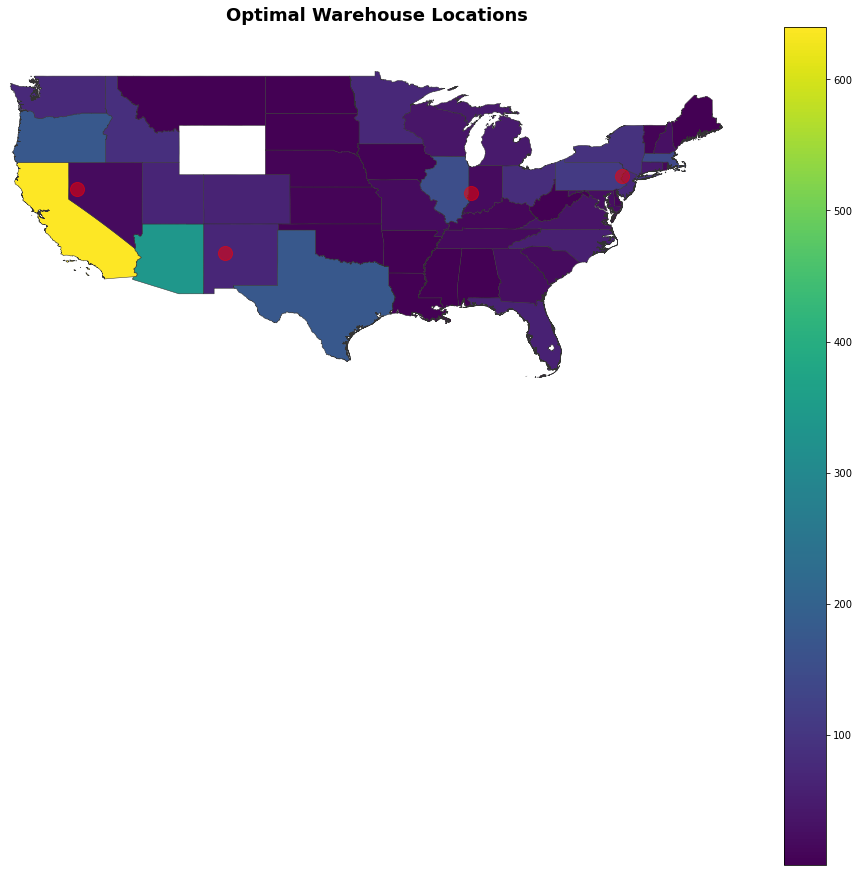

In [20]:
#plot optimal warehouse locations

xlim = (-125, -65)
ylim = (-15, 53)

fig, ax = plt.subplots(figsize=(12, 12), constrained_layout=True)
ax.axis('off')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
fig = mergeo.plot(column='Vendor Count', cmap='viridis', linewidth=0.5, ax=ax, edgecolor='0.2',legend=True)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.5)  
plt.title('Optimal Warehouse Locations',fontsize=18, fontweight='bold')

In [21]:
centers

array([[ -87.34753224,   39.48209837],
       [-119.37472583,   39.81125458],
       [ -75.08023489,   40.88664806],
       [-107.29332151,   34.67188389]])

In [23]:
#physical address of optimal warehouse locations

geolocator = Nominatim(user_agent="OP_loc")

location1 = geolocator.reverse("39.48209837, -87.34753224")
location2 = geolocator.reverse("39.81125458, -119.37472583")
location3 = geolocator.reverse("40.88664806, -75.08023489")
location4 = geolocator.reverse("34.67188389, -107.29332151")

locations = [location1.address, location2.address, location3.address, location4.address]
locations

['National Road Heritage Trail, Terre Haute, Vigo County, Indiana, 47803, United States',
 'Washoe County, Nevada, United States',
 'Sunrise Boulevard, Upper Mount Bethel Township, Northampton County, Pennsylvania, 07833, United States',
 'Cibola County, New Mexico, United States']